# Implementing Echo State Networks 

## Introduction

ESN are basically trained by randomizing an hidden layer larger enough to linearize the data and then training the output layer after discard a transient called washout, training can be done by linear regression or ridge regression.

## ESN Architecture

$$
\begin{align*}
\text{Input Layer} & : \mathbf{u}(t) \in \mathbb{R}^{N_{\text{in}}} \\
\text{Hidden Layer} & : \mathbf{x}(t) \in \mathbb{R}^{N_{\text{res}}} \\
\text{Output Layer} & : \mathbf{y}(t) \in \mathbb{R}^{N_{\text{out}}} \\
\end{align*}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)

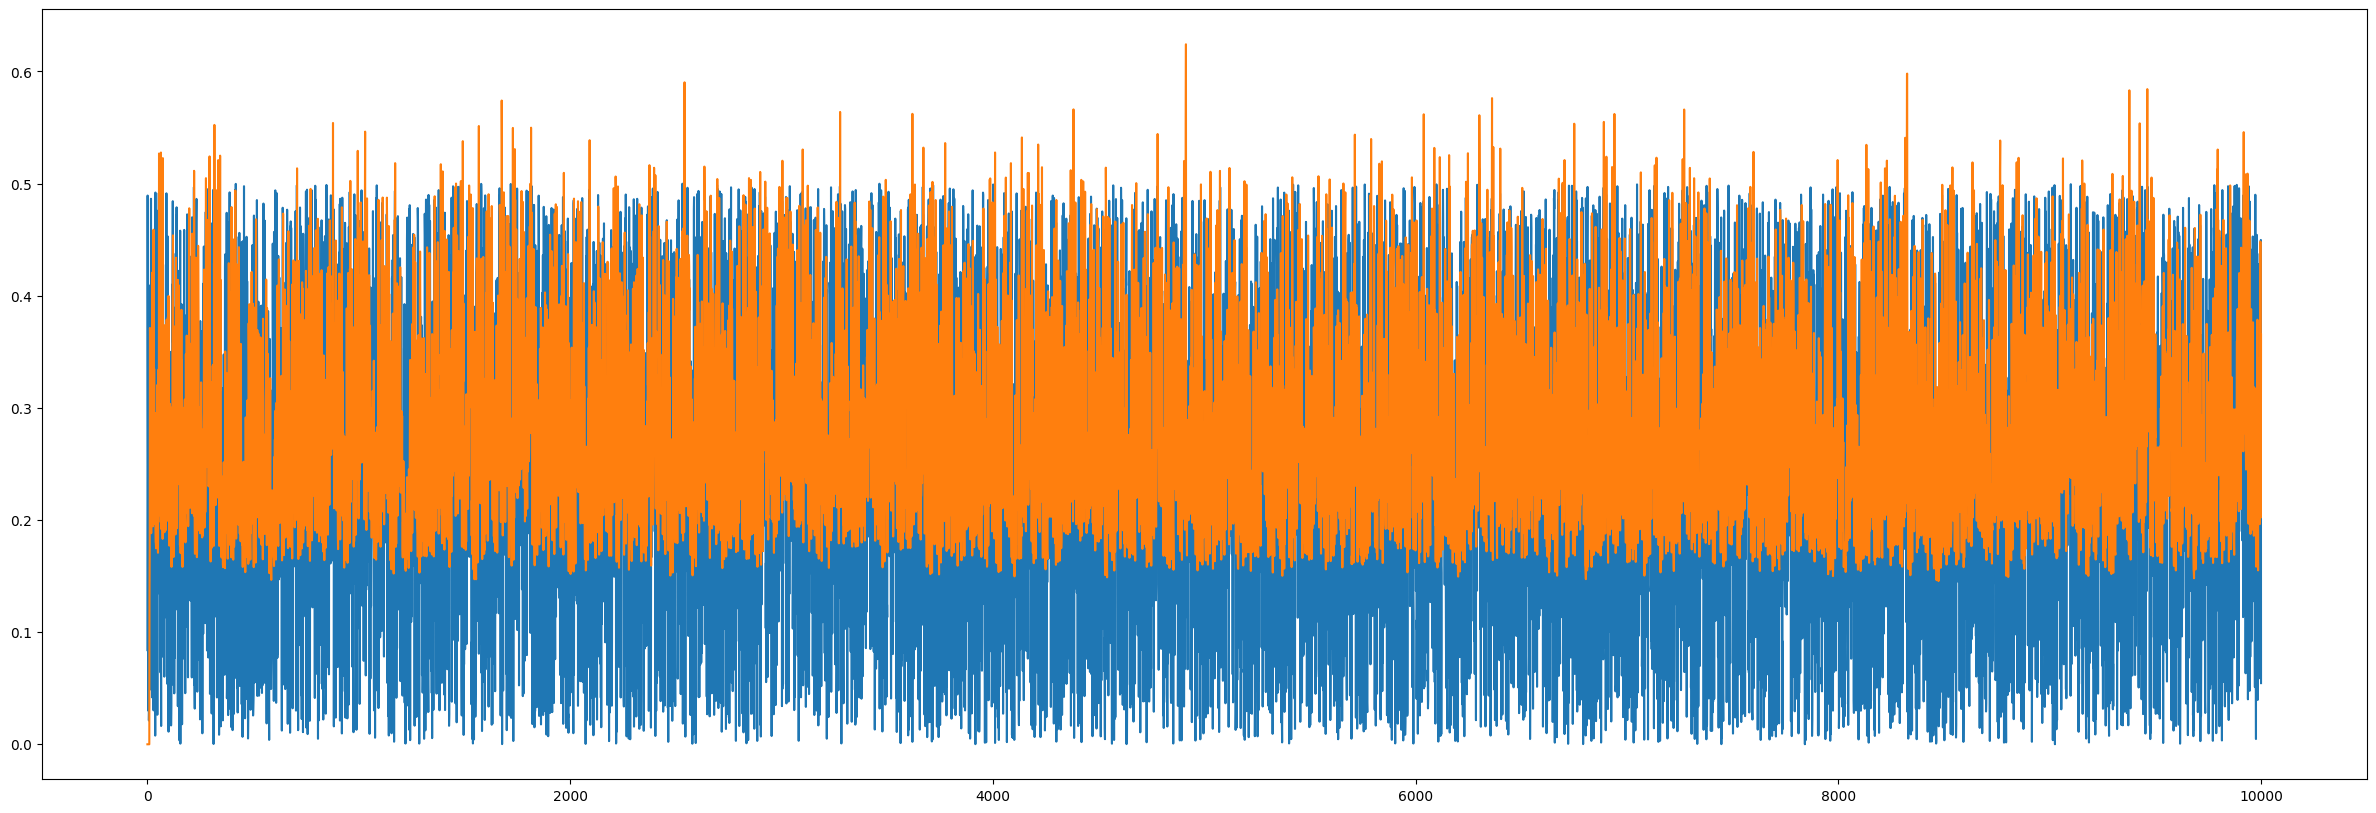

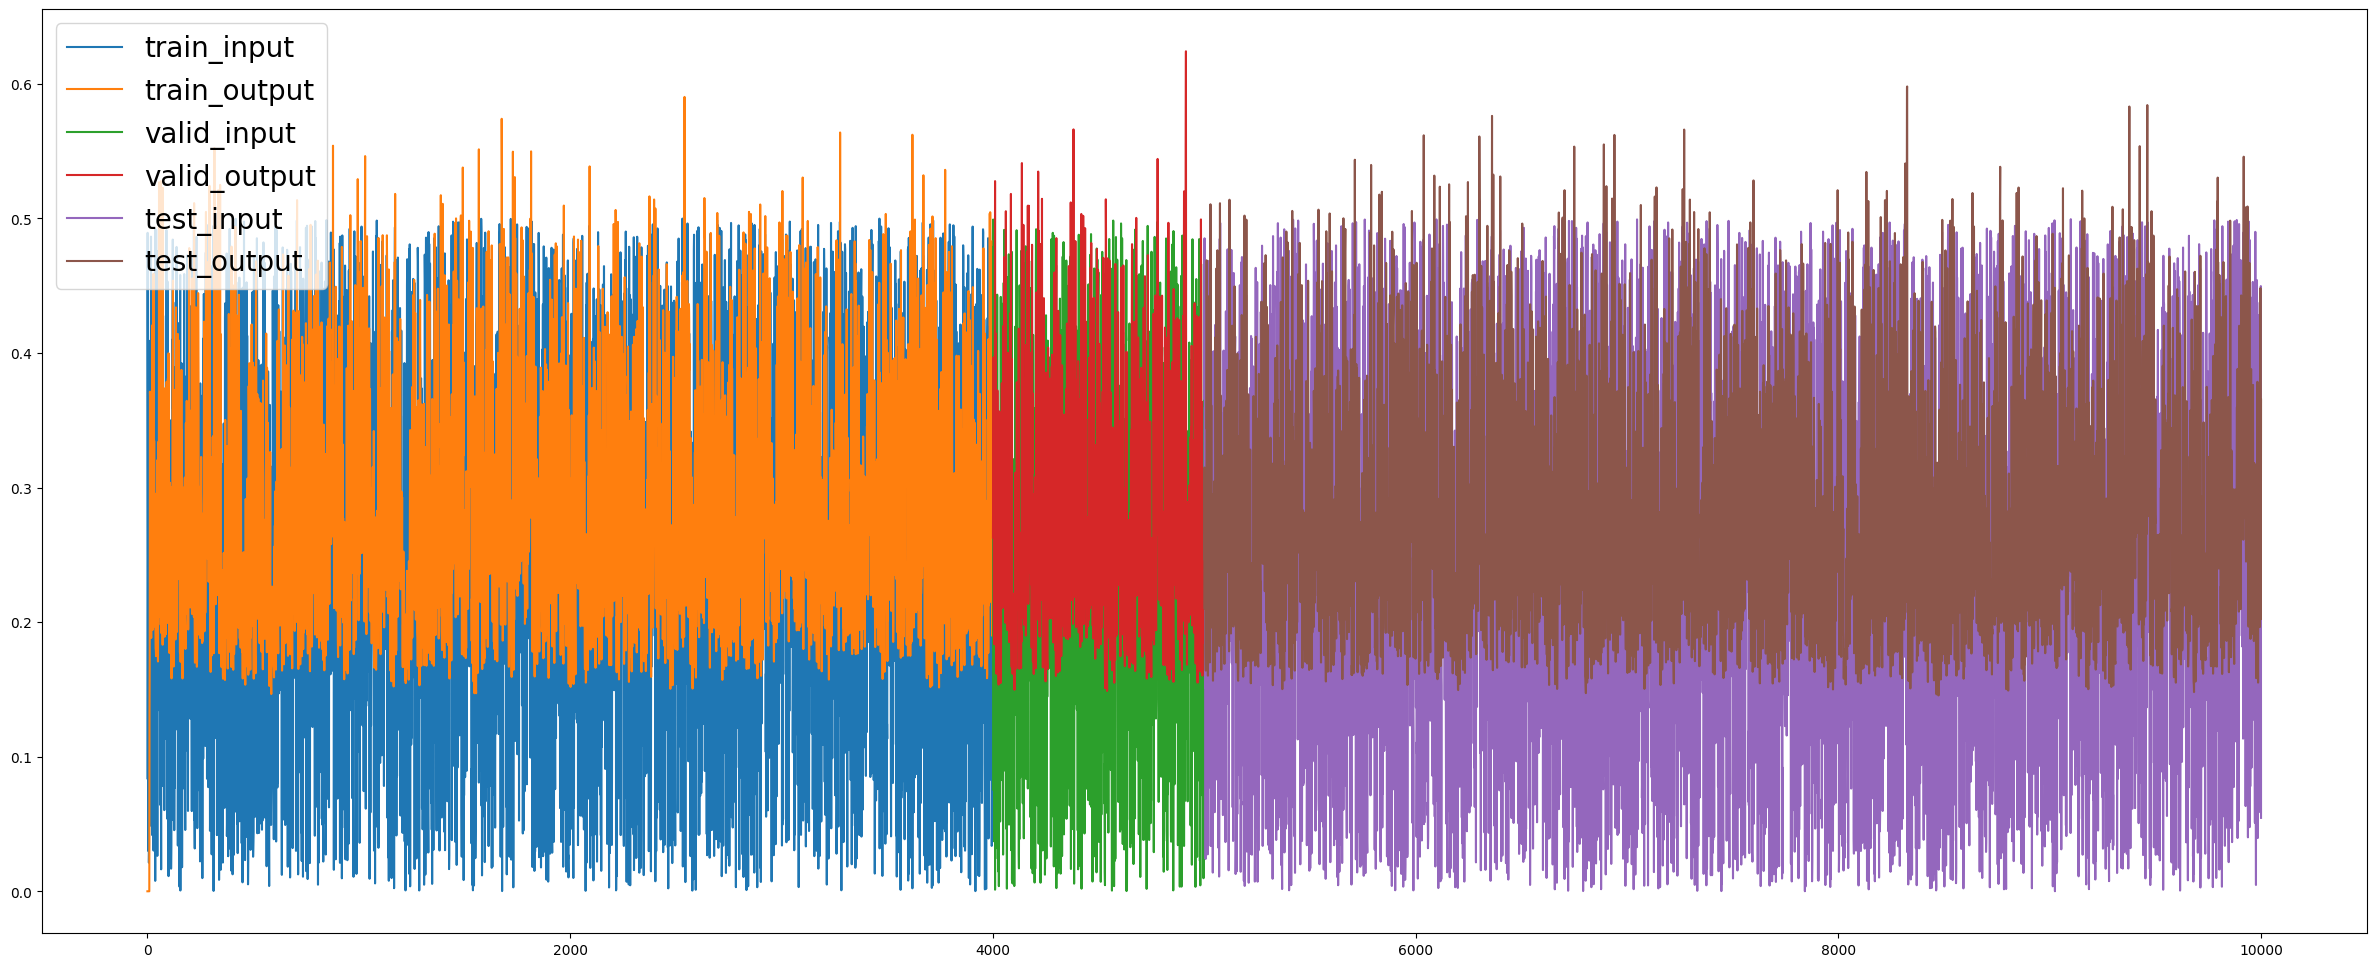

In [3]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [4]:
data_MG17 = pd.read_csv('MG17.csv', header=None)

In [5]:
# divide in train, valid and test the MG17 data, is a single time series of 10000 steps, take 5000 train, 1000 valid and 4000 test
data_MG17.shape
# Index of the timestep is on the columns, so we take first 5000 columns for train, next 1000 for valid and last 4000 for test
train_MG17 = data_MG17.iloc[:, :5000]
valid_MG17 = data_MG17.iloc[:, 5000:6000]
test_MG17 = data_MG17.iloc[:, 6000:]

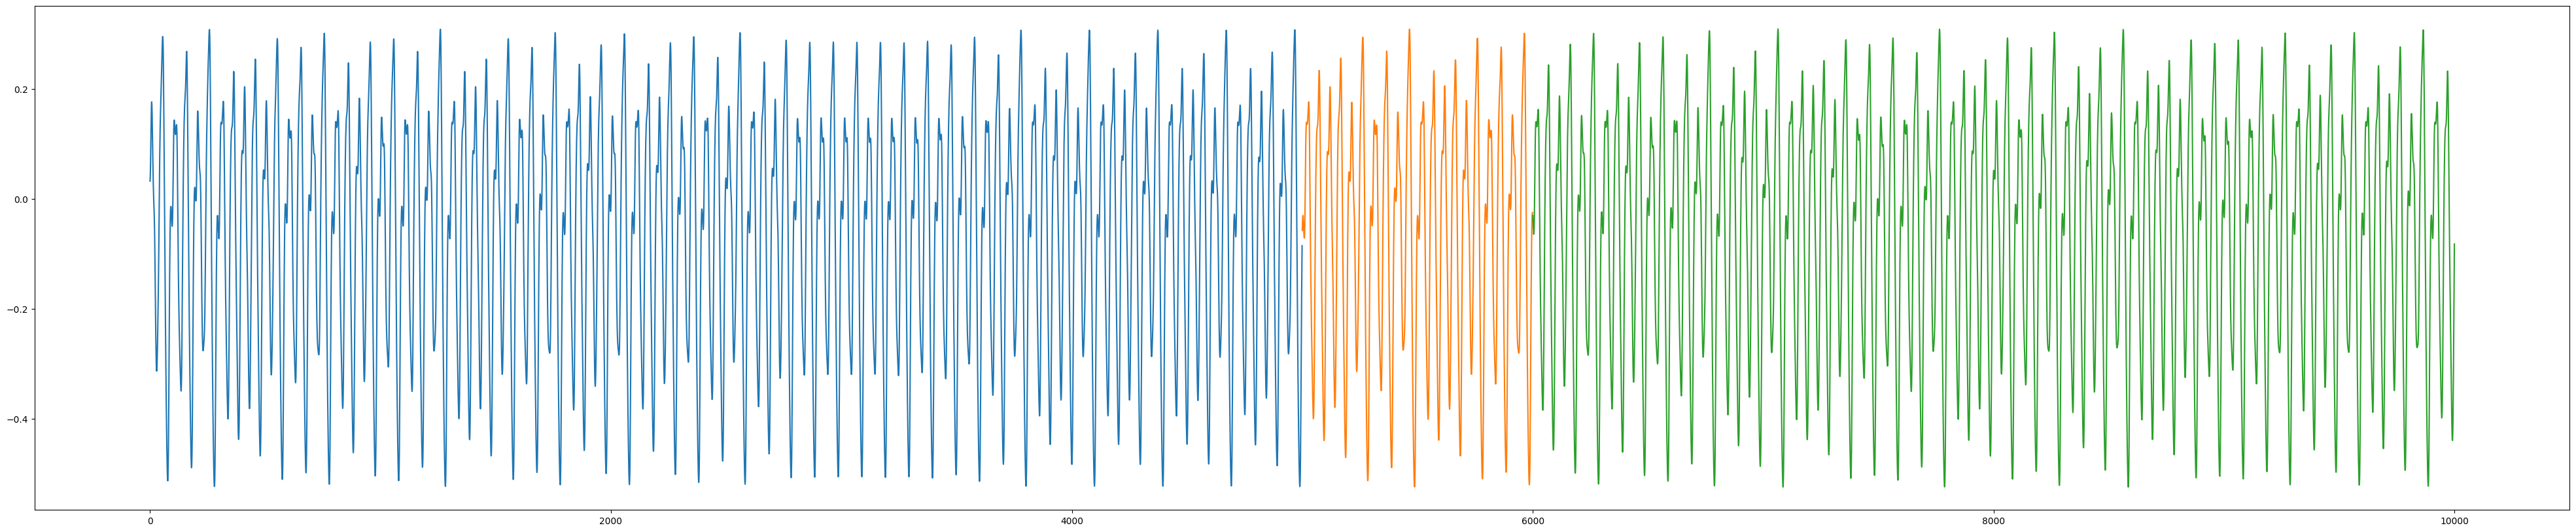

In [6]:
# for each column plot in time series format the data, train, valid and test
plt.figure(figsize=(50,10))
for i in range(0, 1):
    plt.plot(train_MG17.iloc[i])
    plt.plot(valid_MG17.iloc[i])
    plt.plot(test_MG17.iloc[i])

# Let's define our Recurrent Layer as

$$
\begin{align*}
\mathbf{h}(t) & = \tanh(\mathbf{W}_{\text{in}} \mathbf{u}(t) + \mathbf{W_h} \mathbf{x}(t-1) + \mathbf{b}) \\
\end{align*}
$$

### Where we want to enforce this conditions

$$
\begin{align*}
\rho(\mathbf{W_h}) & = max(\lvert \lambda(\mathbf{W_h}) \rvert) < 1 \\
\end{align*}
$$

### And sufficient conditions for the same matrix to have, but we can violate this condition 
$$
\begin{align*}
||\mathbf{W_h}||_2 & < 1 \\
\end{align*}
$$

## Initialization of ESN parameters

In [48]:
# Initalization of W_h (reservoir init) with [-1, 1]

N_h, N_x = 4000, 1

W_r = np.random.uniform(-1, 1, (N_h, N_h))

# Rescaling by spectral radius
recurrent_rho = max(abs(np.linalg.eigvals(W_r)))

rho_enforced = 0.9

W_h = W_r * (rho_enforced / recurrent_rho)

# Initialization of W_x

omega_in = 1.1

# check for the dimensions of the input data
W_x = np.random.uniform(-omega_in, omega_in, (N_h, N_x))

# Rescaling the onput by norm
W_x = omega_in * (W_x / np.linalg.norm(W_x))

# Bias vector initialization   
bias = np.random.uniform(-1, 1, (N_h, N_x))

# Define transient washout 
washout = 1000

state = np.zeros((N_h, 1))

In [45]:
#transform train_input and train_output to numpy arrays
train_input = np.array(train_input).reshape(-1, 1)
train_output = np.array(train_output).reshape(-1, 1)

train_input.shape

(1000, 1)

In [9]:
epochs = 4000
H = []


for t in range(epochs):
    
    state = np.tanh((W_x @ train_input[t]).reshape(-1,1) + (W_h @ state) + bias)
    
    # store state
    H.append(state) 
    
    
# Discard washout
H = H[washout:]

# Convert H in a numpy matrix
H = np.array(H).reshape(-1, N_h)

H.shape

(3000, 2000)

# Training readout layer


In [10]:

target = train_output[washout:epochs]

target.shape

(3000, 1)

Error: 5.4188793548698385e-11


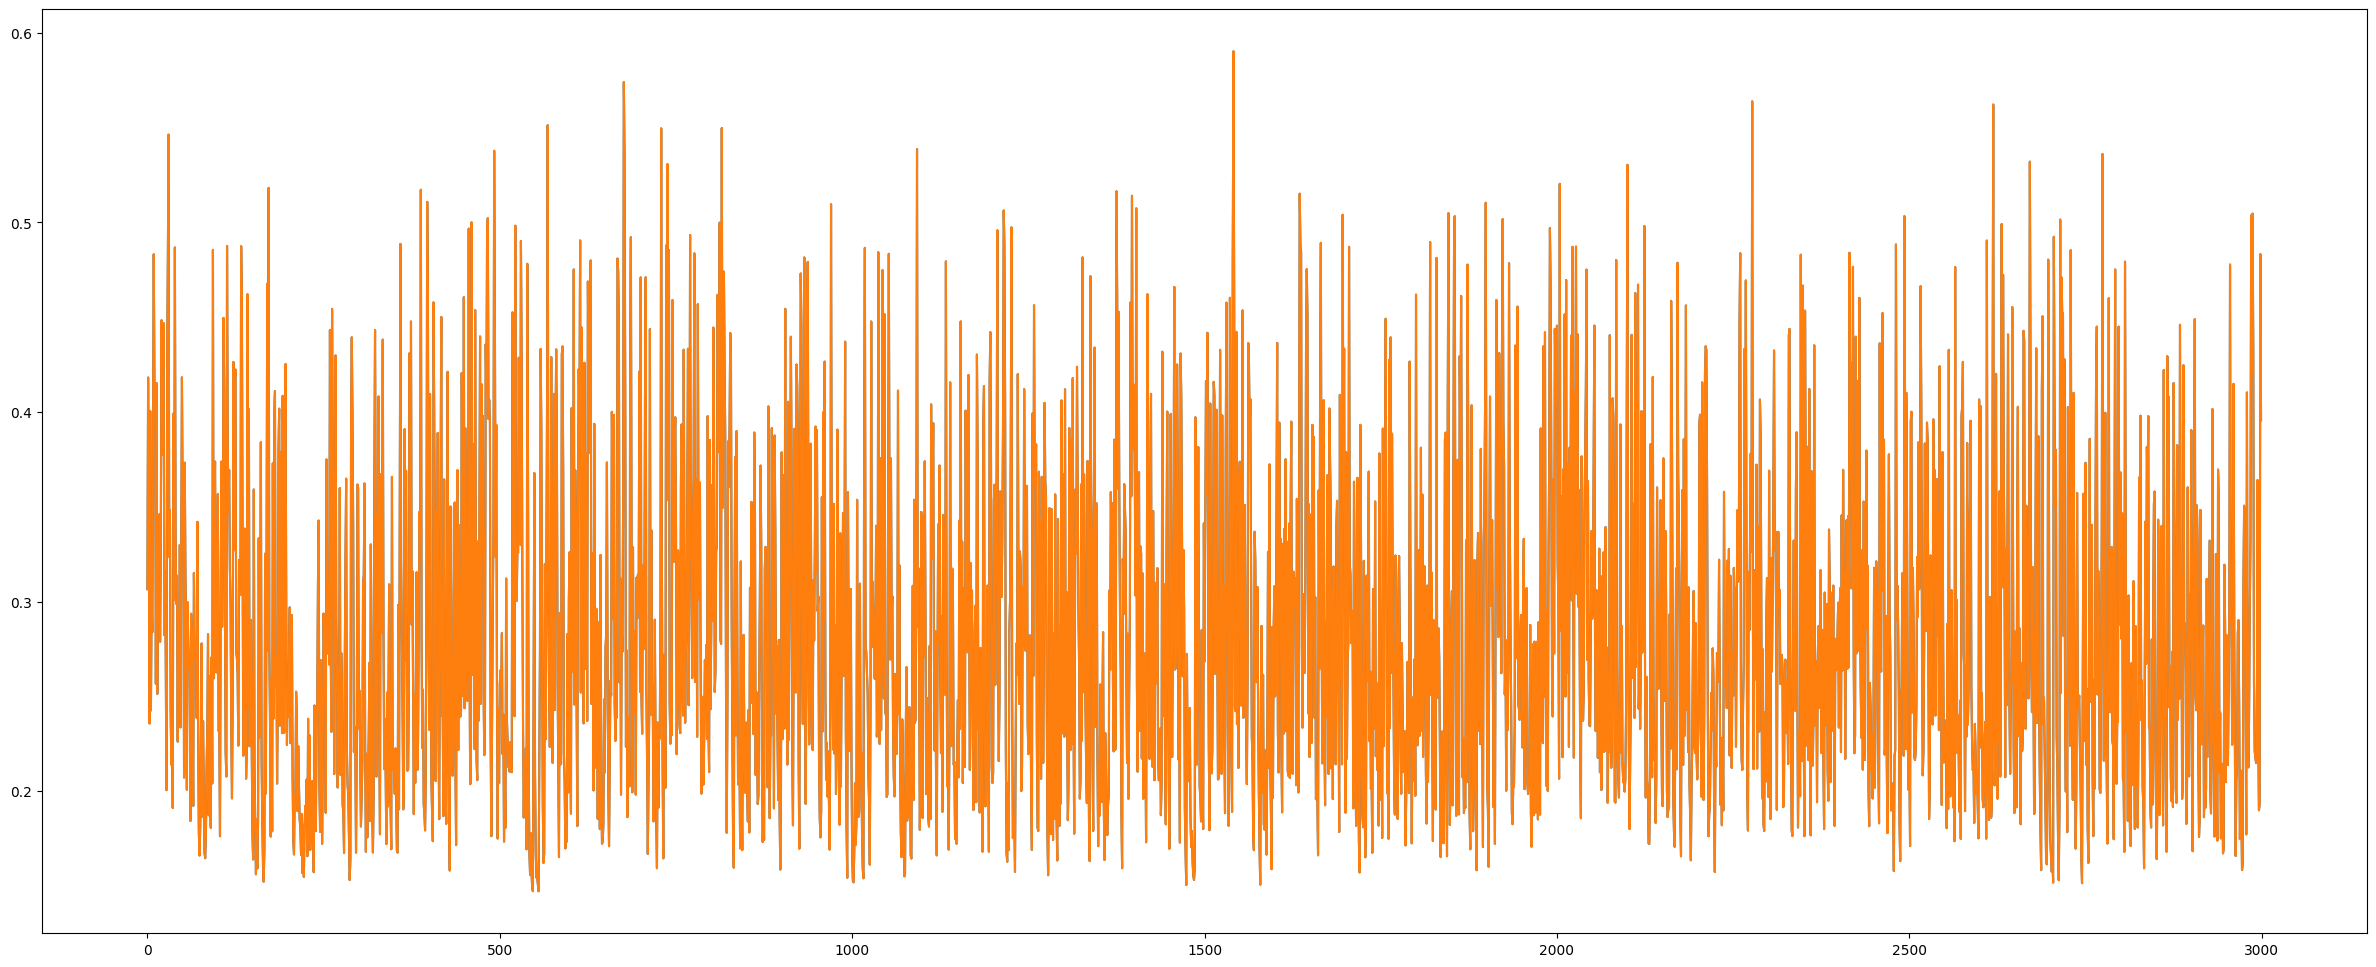

In [11]:
import sklearn  
from sklearn.linear_model import LinearRegression
# Least squares solution
W_out = np.linalg.pinv(H) @ target

# Prediction 
prediction = H @ W_out

error = np.mean((prediction - target) ** 2)
#Error: 0.00038598921265433635

# Plot the prediction
plt.figure(figsize=(30,12))
plt.plot(target)
plt.plot(prediction)

print('Error:', error)


# Fitting on Mackey-Glass Time Series


In [12]:
train_MG17 = np.array(train_MG17).reshape(-1, 1)

(3960, 2000)


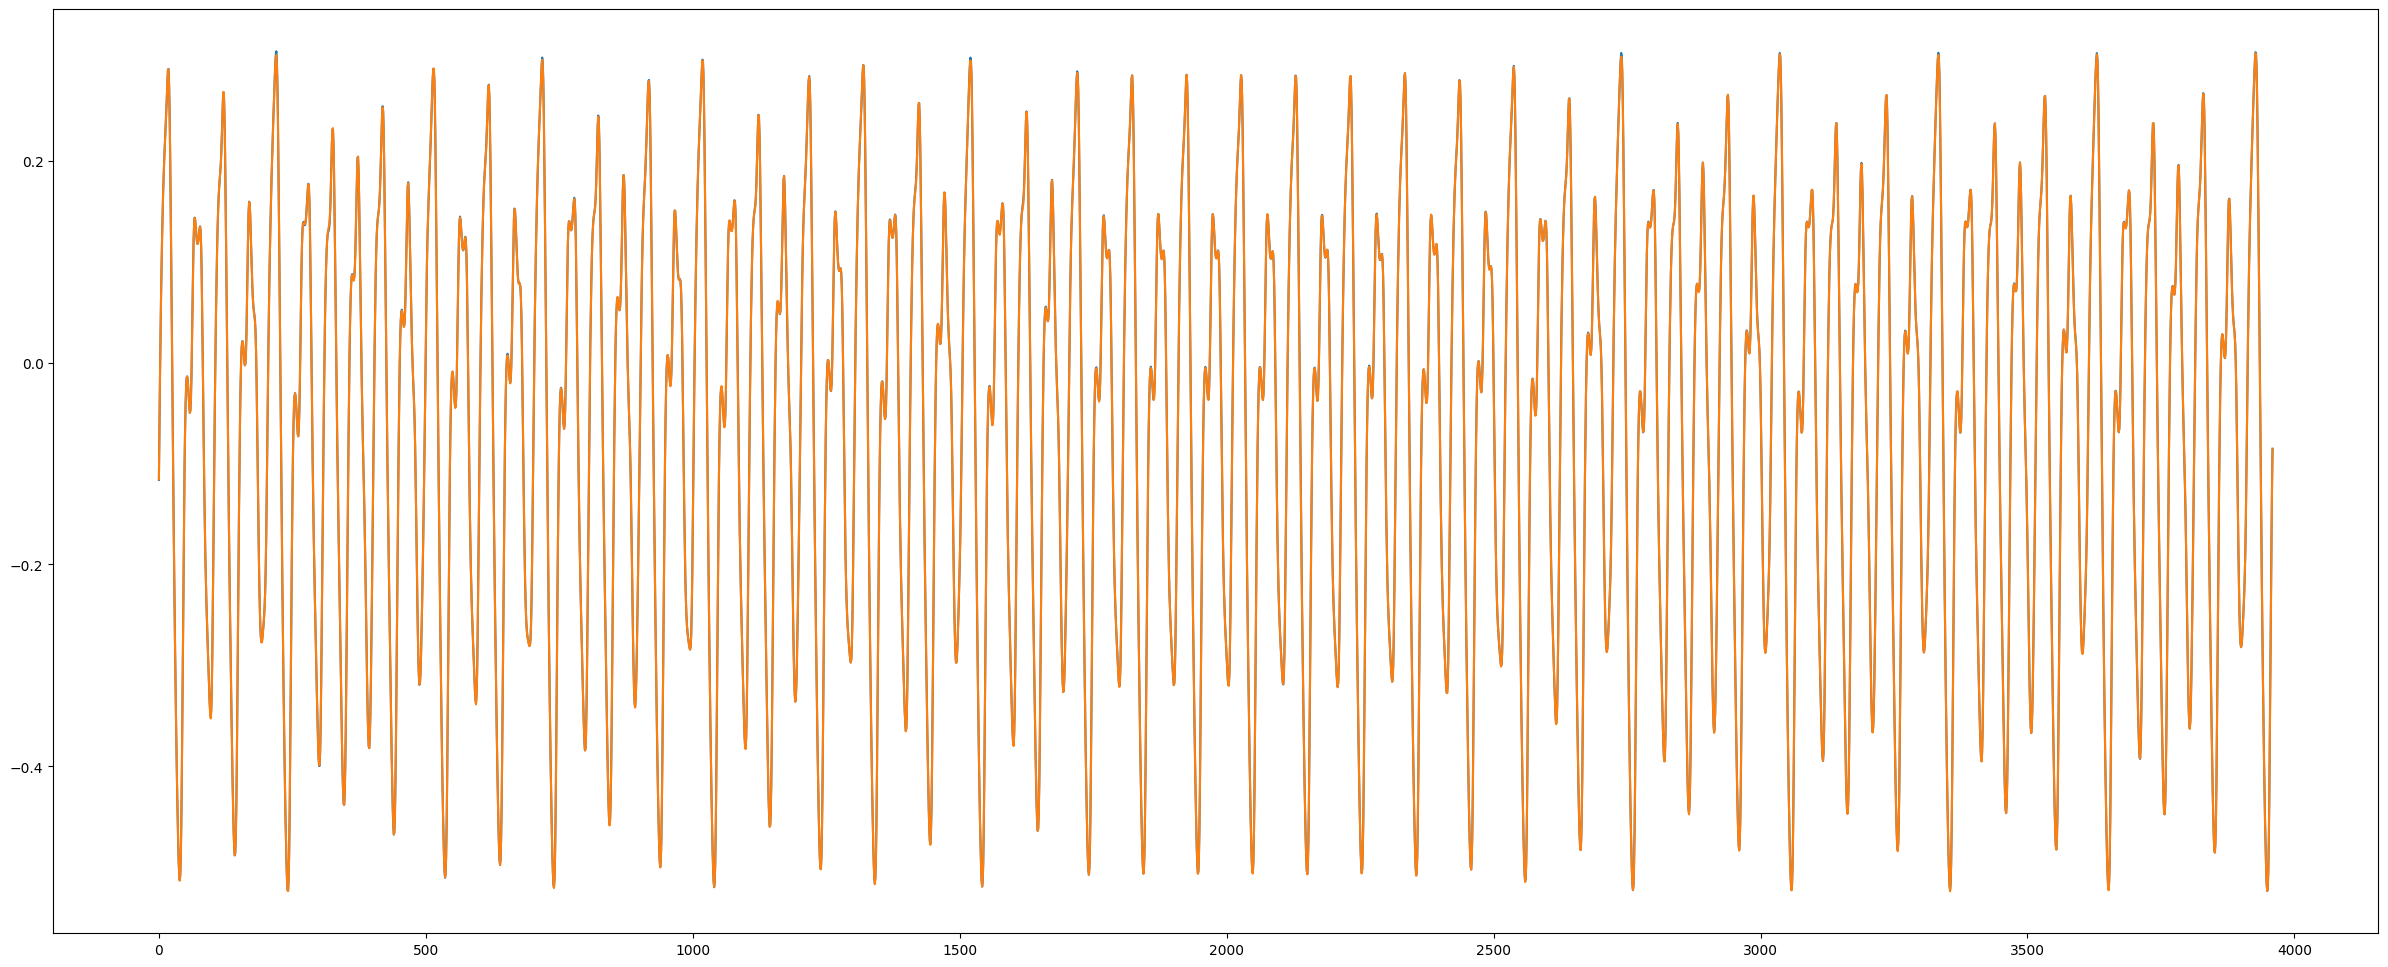

In [13]:
epochs_mg = 5000


delay = 40
train_input = train_MG17[:epochs_mg]
target_delayed = train_MG17[washout+delay:epochs_mg]
H_delayed = []

for t in range(epochs_mg):
    
    state = np.tanh((W_x @ train_MG17[t]).reshape(-1,1) + (W_h @ state) + bias)    
    # store state
    H_delayed.append(state)
   
# Discard washout
H_delayed = H_delayed[washout:-delay]
 
# h to matrix
H_delayed = np.array(H_delayed).reshape(-1, N_h)

print(H_delayed.shape)

# Least squares solution
W_out_delayed = np.linalg.pinv(H_delayed) @ target_delayed

# Prediction
prediction_delayed = H_delayed @ W_out_delayed

error_delayed = np.mean((prediction_delayed - target_delayed) ** 2)

# Plot the prediction
plt.figure(figsize=(30,12))
plt.plot(target_delayed)
plt.plot(prediction_delayed)


# Trying on MNIST dataset sequentially

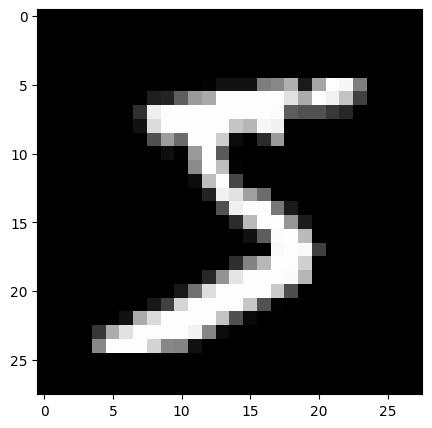

In [14]:
# import mnist
from keras.datasets import mnist

# train, valid and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# plot the first image
plt.figure(figsize=(5,5))
plt.imshow(train_images[0], cmap='gray')



<Figure size 1000x1000 with 0 Axes>

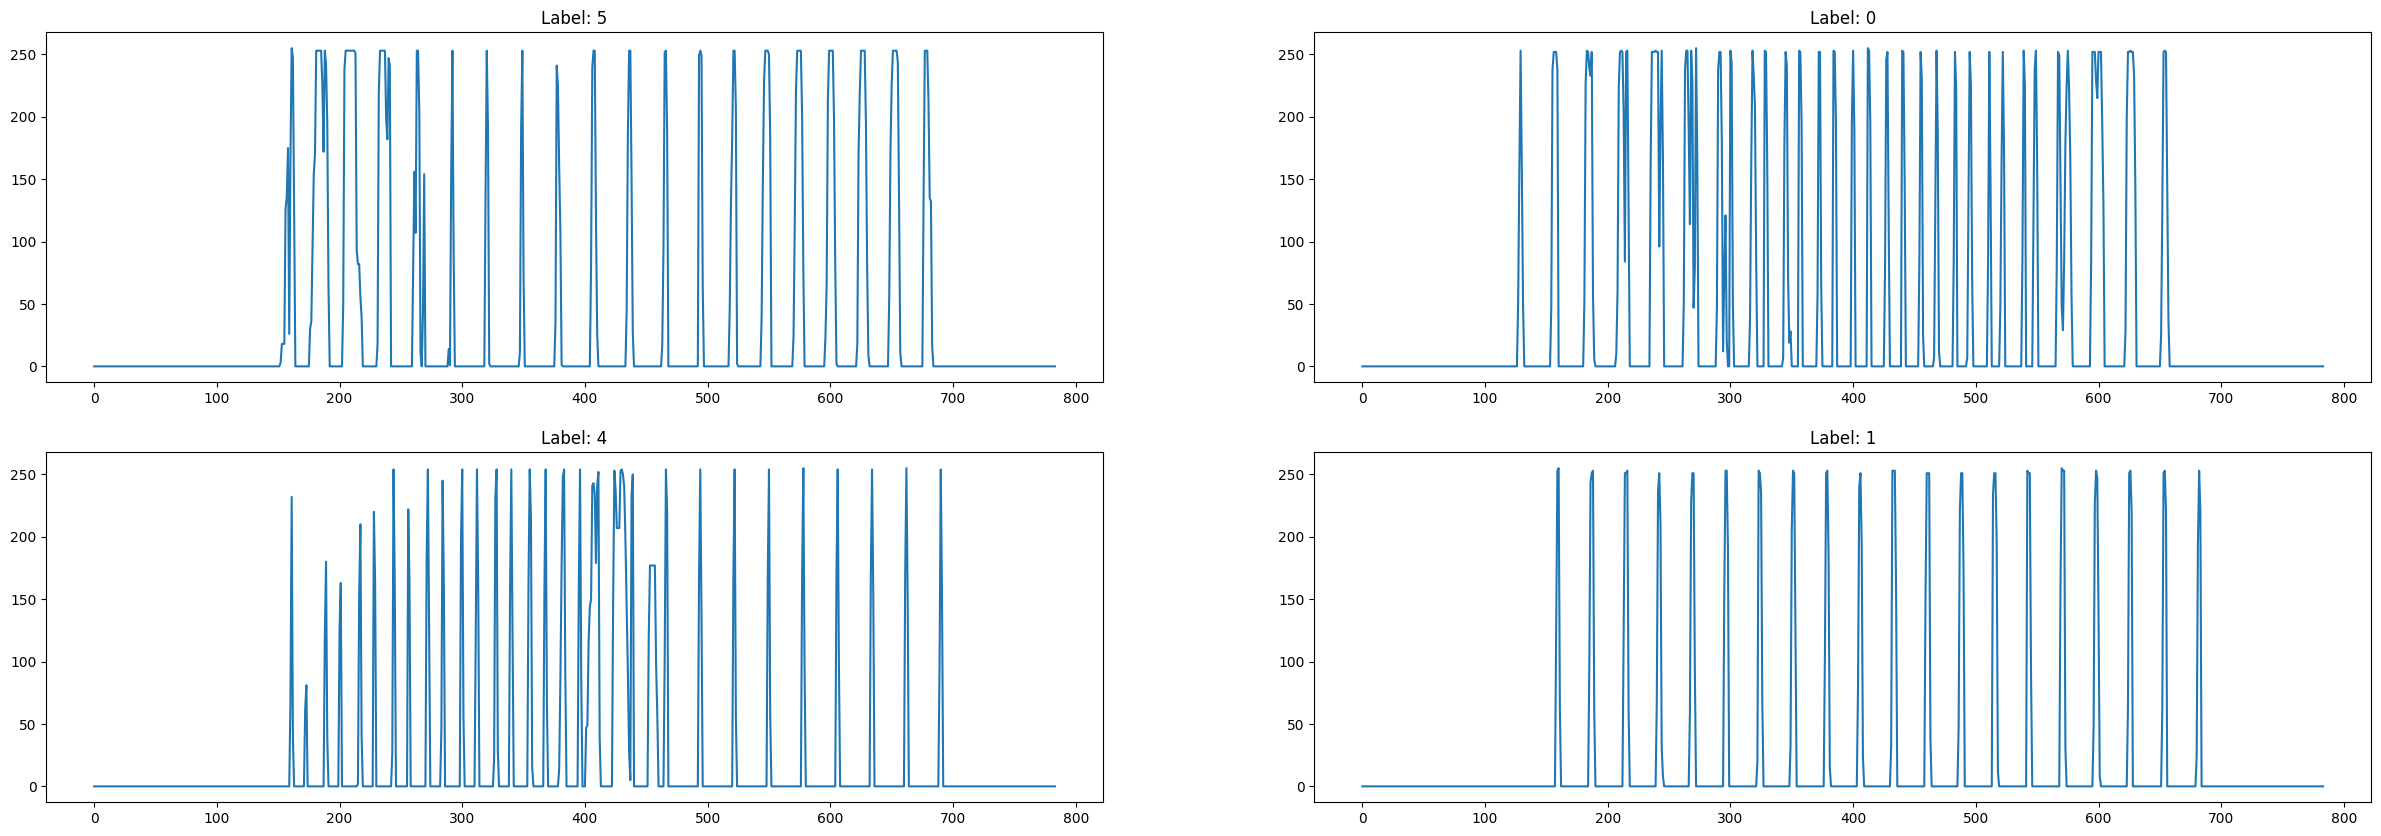

In [15]:
# convert the data to a single vector from 28x28 to 784
train_images = train_images.reshape(60000, 784)
# get test labels
train_labels = train_labels

# show flattened array for space reasons after 100 steps we go to the next line
plt.figure(figsize=(10,10))

# plt the images in time series format
# take 10 images
    
# use the code above and make that we have 4 images in subpltos
plt.figure(figsize=(30,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(train_images[i])
    plt.title('Label: ' + str(train_labels[i]))
    plt.plot()
    

In [16]:
train_images[0].shape

(784,)

In [17]:
train_images = train_images.reshape(-1,1)

In [18]:
#make train input of shape 1, 784


In [19]:
train_output.shape

(4000, 1)

In [50]:
timesteps_MNIST = 2000
washout = 216
train_input = train_images[:timesteps_MNIST]
train_output = train_labels[:timesteps_MNIST]

#take train output to be 7056 long
#N_h = 784

# remove the first 100 steps
#train_output = train_output[washout:]

H_mnist = []    

# state shape will be on all classes so 784x9
#state = np.zeros((N_h, 10))

for i in range(timesteps_MNIST):
    # show all shapes
    
    state = np.tanh((W_x @ train_input[i]).reshape(-1,1) + (W_h @ state) + bias)
    H_mnist.append(state)
    
 
# Discard washout
#H_mnist = H_mnist[washout:]

# Convert H in a numpy matrix
H_mnist = np.array(H_mnist).reshape(-1, N_h)

print(H_mnist.shape)
print(train_output.shape)


(2000, 4000)
(2000,)


In [51]:
# Train with logistic regression the last layer
from sklearn.linear_model import LogisticRegression

# apply logistic regression to get W_out_mnist
W_out_mnist = LogisticRegression(max_iter=1000).fit(H_mnist, train_output)

# Now compute logits
logits = H_mnist @ W_out_mnist.coef_.T + W_out_mnist.intercept_

# Now compute the probabilities
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Now compute the predictions
predictions = np.argmax(probabilities, axis=1)

# Now compute the accuracy
accuracy = np.mean(predictions == train_output)

print('Accuracy:', accuracy)

Accuracy: 0.2215


C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
